In [204]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

In [205]:
save_model = 'D:/projects/ai/poc/homework/training_model.h5'

In [206]:
# 根据箱线图的上下限进行异常值的填充
def boxplot_fill(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 1.5*iqr # 上界
    l_th = col.quantile(0.25) - 1.5*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_trans(x):
        if x > u_th:
            return u_th
        elif x < l_th:
            return l_th
        else:
            return x
    return col.map(box_trans)
def iqr(df, colname, bounds = [.25, .75]):
    s = df[colname]
    q = s.quantile(bounds)
    return df[~s.clip(*q).isin(q)]
 

In [207]:
df_train = pd.read_csv('D:/projects/ai/poc/homework/training_data_20210128.csv')
# 刪除null值


# df=df.head(1000)
#df = pd.read_excel(source_file_path)
#df = pd.read_csv(source_file_path)
df_train = df_train.loc[df_train['LOT_TYPE']=='FDY']
df_train = df_train.loc[df_train['LAYER']!='XX']

df_train['CHIPNAME'] = df_train['CHIPNAME'].str.strip()
df_train = df_train.loc[df_train['CHIPNAME']=='CHIP25']          

df_train['PRIORITY'] = df_train['PRIORITY'].astype(str)
df_train['IS_MAIN_ROUTE'] = df_train['IS_MAIN_ROUTE'].astype(str)
df_train['DATA_DATE'] = df_train['DATA_DATE'].astype(str)
          
df_train['DATA_DATE'] = pd.to_datetime(df_train['DATA_DATE'], infer_datetime_format=True)
df_train['WS_DATE'] = pd.to_datetime(df_train['WS_DATE'], infer_datetime_format=True)

df_train = df_train.assign(PROCESSED_DAYS = ((df_train['DATA_DATE'] -df_train['WS_DATE'])/pd.Timedelta(1, 'D'))
.fillna(0).astype('float64'))

df_train['ACTUAL_WP_OUT'] =pd.to_datetime(df_train['ACTUAL_WP_OUT'], infer_datetime_format=True)

df_train = df_train.assign(CYCLE_TIME=((df_train['ACTUAL_WP_OUT']-df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))

df_train = df_train.assign(REMAIN_DAYS=((df_train['ACTUAL_WP_OUT']-df_train['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))


In [208]:
#print(sum(pd.isnull(df_train['REMAIN_LAYER_SEQ'])))

In [209]:
df_test = pd.read_csv('D:/projects/ai/poc/homework/testing_data_20210128.csv')

df_test = df_test.loc[df_test['LOT_TYPE']=='FDY']
df_test = df_test.loc[df_test['LAYER']!='XX']
df_test['CHIPNAME'] = df_test['CHIPNAME'].str.strip()
df_test = df_test.loc[df_test['CHIPNAME']=='CHIP25']   
     

df_test['PRIORITY'] = df_test['PRIORITY'].astype(str)
df_test['IS_MAIN_ROUTE'] = df_test['IS_MAIN_ROUTE'].astype(str)
df_test['DATA_DATE'] = df_test['DATA_DATE'].astype(str) 

df_test['DATA_DATE'] = pd.to_datetime(df_test['DATA_DATE'], infer_datetime_format=True)

df_test['WS_DATE'] = pd.to_datetime(df_test['WS_DATE'], infer_datetime_format=True)
df_test = df_test.assign(PROCESSED_DAYS = ((df_test['DATA_DATE'] -df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_test['ACTUAL_WP_OUT'] =pd.to_datetime(df_test['ACTUAL_WP_OUT'], infer_datetime_format=True)

df_test = df_test.assign(CYCLE_TIME=((df_test['ACTUAL_WP_OUT']-df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))

df_test = df_test.assign(REMAIN_DAYS=((df_test['ACTUAL_WP_OUT']-df_test['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))

In [210]:
#移除cycle time outlier
df_train =iqr(df_train,'CYCLE_TIME',[0, .75])    
df_test =iqr(df_test,'CYCLE_TIME',[0, .75])    
# print(df2_test.isnull().sum())
# print(df2_train.isnull().sum

In [211]:
# df.fillna(0, inplace=True)
# df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
#df = train_df.drop(train_df.loc[:, '0E':'ZL'].columns, axis = 1)
df2_train = df_train.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','OP_NO','LOT_ID'])
df2_train = df2_train.drop(df2_train.loc[:, '0E':'ZL'].columns, axis = 1) 

df2_train = df2_train.drop(columns=['CYCLE_TIME','CHIPNAME'])


In [212]:

df2_test = df_test.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','OP_NO','LOT_ID'])
df2_test = df2_test.drop(df2_test.loc[:, '0E':'ZL'].columns, axis = 1) 
df2_test = df2_test.drop(columns=['CYCLE_TIME','CHIPNAME'])


In [213]:
#df_train.isnull().sum().sort_values(ascending = False).head()
#sum(pd.isnull(df_train['REMAIN_LAYER_SEQ']))

In [214]:
# 1. 查看缺失情况

df2_train = df2_train.dropna() # 刪除null值
df2_test = df2_test.dropna()# 刪除null值
# print(df2_test.isnull().sum())
# print(df2_train.isnull().sum())
# print(df_train.isnull().sum())
# print(df_test.isnull().sum())
 

In [215]:



# 在进行数据分析前，一般需要了解数据的缺失情况，在Python中可以构造一个lambda函数来查看缺失值，该lambda函数中，sum(col.isnull())表示当前列有多少缺失，col.size表示当前列总共多少行数据：
# df2_test.apply(lambda col:sum(col.isnull())/col.size)
# df2_train.apply(lambda col:sum(col.isnull())/col.size)

#2. 以指定值填补
#  df2_test.score.fillna(sample.score.mean()) 填补方法为均值
#  df2_test.score.fillna(sample.score.median()) 分位数等方法进行填补
#pandas数据框提供了fillna方法完成对缺失值的填补，例如对sample表的列score填补缺失值，填补方法为均值：

# df_train = df_train.dropna()
# df_test = df_test.dropna()

#03 噪声值处理 噪声值指数据中有一个或几个数值与其他数值相比差异较大，又称为异常值、离群值(outlier)。
#1. 盖帽法 盖帽法将某连续变量均值上下三倍标准差范围外的记录替换为均值上下三倍标准差值，即盖帽处理
#Python中可自定义函数完成盖帽法。如下所示，参数x表示一个pd.Series列，quantile指盖帽的范围区间，默认凡小于百分之1分位数和大于百分之99分位数的值将会被百分之1分位数和百分之99分位数替代：


In [216]:
# def cap(x,quantile=[0.01,0.99]):
#     """盖帽法处理异常值
#     Args：
#         x：pd.Series列，连续变量
#         quantile：指定盖帽法的上下分位数范围
#     """

# # 生成分位数
#     Q01,Q99=x.quantile(quantile).values.tolist()

# # 替换异常值为指定的分位数
#     if Q01 > x.min():
#         x = x.copy()
#         x.loc[x<Q01] = Q01

#     if Q99 < x.max():
#         x = x.copy()
#         x.loc[x>Q99] = Q99

#     return(x)

In [217]:
# cap(df_train['REMAIN_DAYS'])
# df_train['REMAIN_DAYS']
# # 查看离群情况
# df_train['REMAIN_DAYS'].hist() #看長條圖
# plt.show()
# df_train[['REMAIN_DAYS']].boxplot()
# plt.show()
# # # 填充效果查看
# # boxplot_fill(df2_train['REMAIN_DAYS']).hist()
# # # 进行赋值
# # df['REMAIN_DAYS'] = boxplot_fill(df['REMAIN_DAYS'])
# # plt.show()

In [218]:
labelencoder = LabelEncoder()
# df2_train['PRIORITY'] = labelencoder.fit_transform(df2_train['PRIORITY'])
# df2_train['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2_train['IS_MAIN_ROUTE'])
# df2_train['STATUS'] = labelencoder.fit_transform(df2_train['STATUS'])
# df2_train['CHIPNAME'] = labelencoder.fit_transform(df2_train['CHIPNAME'])
# df2_train['OP_NO'] = labelencoder.fit_transform(df2_train['OP_NO'])


for col in df2_train[['PRIORITY','IS_MAIN_ROUTE','STATUS', 'LAYER']]:
    df2_train[col]=labelencoder.fit_transform(df2_train[col])
df2_train.info()
#==============================

#1.label Encoder 手動轉換  自己製作STATUS
# STATUS_mapping={'WAITING':0,'PROCESSING':1}
# train_df['STATUS']=train_df['STATUS'].map(STATUS_mapping)
# test_df['STATUS']=test_df['STATUS'].map(STATUS_mapping)

#2.label Encoder 自動轉換 
# category_col =['CHIPNAME', 'LAYER','LOT_TYPE'] 

# # 大部分的模型都是基於數學運算，字串無法套入數學模型進行運算，在此先對其進行Label encoding編碼，我們從 sklearn library中導入 LabelEncoder class，對第一行資料進行fit及transform並取代之
# for col in category_col:
#     train_df[col] = labelEncoder.fit_transform(train_df[col])
# for col in category_col:
#     test_df[col] = labelEncoder.fit_transform(test_df[col])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10512 entries, 2242 to 222838
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STATUS            10512 non-null  int32  
 1   LAYER             10512 non-null  int32  
 2   REMAIN_LAYER_SEQ  10512 non-null  float64
 3   REMAIN_OP_SEQ     10512 non-null  float64
 4   PRIORITY          10512 non-null  int32  
 5   WIP_QTY           10512 non-null  int64  
 6   IS_MAIN_ROUTE     10512 non-null  int32  
 7   PROCESSED_DAYS    10512 non-null  float64
 8   REMAIN_DAYS       10512 non-null  float64
dtypes: float64(4), int32(4), int64(1)
memory usage: 657.0 KB


array([[ 1.        ,  1.        , 11.        , ...,  1.        ,
        29.24513889, 26.33819444],
       [ 1.        ,  1.        , 11.        , ...,  1.        ,
        29.24444444, 23.85694444],
       [ 1.        ,  0.        , 11.        , ...,  1.        ,
        25.26527778, 27.12291667],
       ...,
       [ 1.        ,  1.        ,  7.        , ...,  1.        ,
        41.25555556, 21.42291667],
       [ 1.        ,  1.        ,  7.        , ...,  1.        ,
        42.23055556, 16.64513889],
       [ 1.        ,  1.        ,  4.        , ...,  1.        ,
        57.26458333, 10.42291667]])

In [219]:

#
#============================
X_dropped = np.asarray(df2_train.drop('REMAIN_DAYS', axis=1))
Y_dropped = np.asarray(df2_train['REMAIN_DAYS'])
# Separate labels with features  
# 將 dataframe 轉換為 array
# ndarray = df2.values  
# train_labels = ndarray[:,9]    # Labels are the values we want to predict
# train_features = ndarray[:,:9] # Remove the labels from the features

#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)


In [220]:
#One hot encoding  使用Pandas進行   
# get_dummies可以直接轉字串，反而無法轉換數字
# get_dummies沒指定columns，會全部轉換
# category_col_1 =[ 'STATUS', 'CHIPNAME','OP_NO']            
# # df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
# df2_train = pd.get_dummies(df2_train, columns=category_col_1, drop_first=True)
# 使用get_dummies進行Category轉換    
# df2_train = pd.get_dummies(data=df2_train, columns=['STATUS']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['CHIPNAME']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['OP_NO']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['PRIORITY'])
# df2_train = pd.get_dummies(data=df2_train, columns=['IS_MAIN_ROUTE']) 
# ct=ColumnTransformer([("STATUS", OneHotEncoder(), [0,1])], remainder = 'passthrough')
# X_dropped=ct.fit_transform(pd.DataFrame(X_dropped))

X_dropped

array([[ 1.        ,  4.        , 11.        , ..., 25.        ,
         1.        , 29.24513889],
       [ 1.        ,  4.        , 11.        , ..., 25.        ,
         1.        , 29.24444444],
       [ 0.        ,  4.        , 11.        , ..., 25.        ,
         1.        , 25.26527778],
       ...,
       [ 1.        , 15.        ,  7.        , ..., 25.        ,
         1.        , 43.24027778],
       [ 1.        , 15.        ,  7.        , ..., 25.        ,
         1.        , 41.25555556],
       [ 1.        , 15.        ,  7.        , ..., 25.        ,
         1.        , 42.23055556]])

In [221]:
 
# df2_test['PRIORITY'] = labelencoder.fit_transform(df2_test['PRIORITY'])
# df2_test['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2_test['IS_MAIN_ROUTE'])
# df2_test['STATUS'] = labelencoder.fit_transform(df2_test['STATUS'])
# df2_test['CHIPNAME'] = labelencoder.fit_transform(df2_test['CHIPNAME'])
# df2_test['OP_NO'] = labelencoder.fit_transform(df2_test['OP_NO'])
# df2_test.info()
for col in df2_test[['PRIORITY','IS_MAIN_ROUTE','STATUS', 'LAYER']]:
    df2_test[col]=labelencoder.fit_transform(df2_test[col])
df2_test.info()
#=======================================
#df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
#One hot encoding  使用Pandas進行   
# get_dummies可以直接轉字串，反而無法轉換數字
# get_dummies沒指定columns，會全部轉換
# category_col_1 =[ 'STATUS', 'CHIPNAME','OP_NO']            
# # df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
# df2_test = pd.get_dummies(df2_test, columns=category_col_1, drop_first=True)


X_dropped_test = np.asarray(df2_test.drop('REMAIN_DAYS', axis=1))
Y_dropped_test = np.asarray(df2_test['REMAIN_DAYS'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 407 to 780
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STATUS            231 non-null    int32  
 1   LAYER             231 non-null    int32  
 2   REMAIN_LAYER_SEQ  231 non-null    float64
 3   REMAIN_OP_SEQ     231 non-null    float64
 4   PRIORITY          231 non-null    int32  
 5   WIP_QTY           231 non-null    int64  
 6   IS_MAIN_ROUTE     231 non-null    int32  
 7   PROCESSED_DAYS    231 non-null    float64
 8   REMAIN_DAYS       231 non-null    float64
dtypes: float64(4), int32(4), int64(1)
memory usage: 14.4 KB


In [222]:

#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

In [223]:
# ct=ColumnTransformer([("STATUS", OneHotEncoder(), [0,1])], remainder = 'passthrough')
# X_dropped_test=ct.fit_transform(pd.DataFrame(X_dropped_test))
 
 

In [224]:
#rescaling 特徵縮放(0~1) 特徵最小/全距
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
X_dropped = minmax_scale.fit_transform(X_dropped)  
X_dropped_test = minmax_scale.fit_transform(X_dropped_test)  


In [225]:
X_dropped

array([[1.        , 0.15384615, 0.38461538, ..., 1.        , 1.        ,
        0.46817618],
       [1.        , 0.15384615, 0.38461538, ..., 1.        , 1.        ,
        0.468165  ],
       [0.        , 0.15384615, 0.38461538, ..., 1.        , 1.        ,
        0.4041262 ],
       ...,
       [1.        , 0.57692308, 0.23076923, ..., 1.        , 1.        ,
        0.69340724],
       [1.        , 0.57692308, 0.23076923, ..., 1.        , 1.        ,
        0.66146608],
       [1.        , 0.57692308, 0.23076923, ..., 1.        , 1.        ,
        0.67715726]])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________

[Info] 訓練中...
Train on 10512 samples
Epoch 1/50
10512/10512 - 1s - loss: 89.1529 - accuracy: 0.0000e+00
Epoch 2/50
10512/10512 - 1s - loss: 8.0884 - accuracy: 0.0000e+00
Epoch 3/50
10512/10512 - 1s - loss: 7.7266 - accuracy: 0.0000e+00
Epoch 4/50
10512/

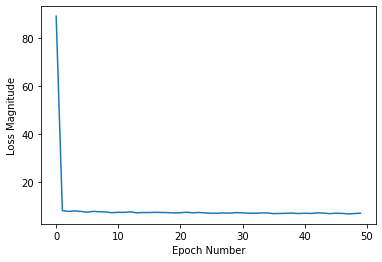

In [226]:
#將Layer放入Model中
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]),
    tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(units=32),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)

    ])
# model = tf.keras.Sequential()  
# # 輸入層
# #model.add(Dense(units=3, input_dim=1, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=10, input_dim=9, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))

# # 隱藏層
# #model.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=20, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=30, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=40, kernel_initializer='uniform', activation='relu', kernel_regularizer='l2'))
# model.add(tf.keras.layers.Dropout(0.2))

# # 輸出層
# #model.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# model.add(tf.keras.layers.Dense(units=1)) #如果我們再做二元分類，輸出層就要使用sigmoid
#print("\n[Info] Show model summary...")  
model.summary()
print("\n[Info] 訓練中...")  

#compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy']) 
 
train_history = model.fit(x=X_dropped, y=Y_dropped, epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證


# early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
# train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2) 
 
# train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
print("Finished training the model")
model.save(save_model)

plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(train_history.history['loss'])
plt.show()


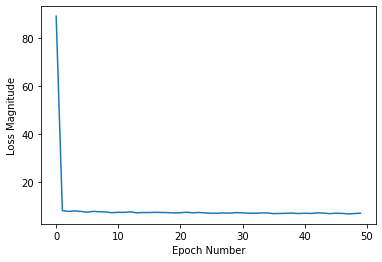

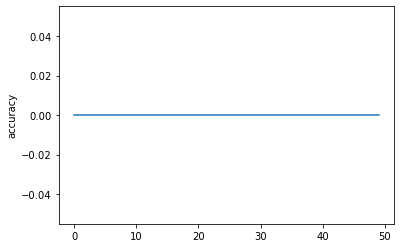

In [227]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(train_history.history['loss'], label = 'loss')

plt.show()
plt.ylabel("accuracy")
plt.plot(train_history.history['accuracy'], label = 'accuracy')# 準確度

plt.show()

In [228]:
#import matplotlib.pyplot as plt

def acc_draw(hist):
    plt.plot(hist.history['accuracy'], label = 'train')
    plt.plot(hist.history['val_accuracy'], label = 'validation')
    plt.title("train acc vs validation acc")
    plt.xlabel("Epochs")
    plt.ylabel("acc")
    plt.legend()
    plt.show()
def loss_draw(hist):
    plt.style.use('ggplot')
    plt.plot(hist.history['loss'], label = 'train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title("train loss vs validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
 

In [229]:
#model.predict(X_dropped_test)

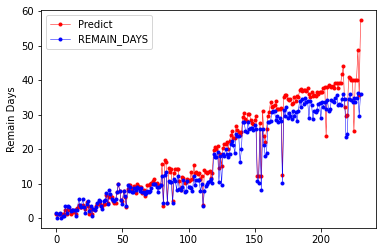

In [230]:
# df_test3.info()
#model = tf.keras.models.load_model(save_model)
# print(model.predict(df_test3))

# plt.xlabel('Seq Number')
plt.ylabel("Remain Days")

plt.plot(model.predict(X_dropped_test), label = "Predict", color='red', marker='.',linewidth = '0.5')
plt.plot(Y_dropped_test, label = "REMAIN_DAYS", color='blue', marker='.',linewidth = '0.5')
plt.legend()
plt.show()

In [231]:
y_predict = model.predict(X_dropped_test)

df2_test['predict'] = y_predict


In [232]:
df2_test

,STATUS,LAYER,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,PRIORITY,WIP_QTY,IS_MAIN_ROUTE,PROCESSED_DAYS,REMAIN_DAYS,predict
407,1,20,1.0,20.0,2,25,0,60.219444,1.440278,1.340099
408,0,20,1.0,2.0,2,25,0,60.218750,0.114583,1.340099
411,0,20,1.0,11.0,2,25,0,60.215972,1.322917,1.340099
412,1,20,1.0,19.0,2,25,0,60.214583,1.442361,1.340099
419,0,20,1.0,2.0,2,25,0,61.257639,0.187500,1.340099
...,...,...,...,...,...,...,...,...,...,...
776,0,7,15.0,339.0,2,25,0,24.242361,33.606250,40.120701
777,1,19,14.0,336.0,2,25,0,24.242361,34.719444,40.145813
778,0,2,20.0,410.0,2,25,0,16.236806,36.232639,48.756847
779,0,18,22.0,434.0,0,25,0,11.283333,29.713194,35.590740


In [233]:
df2_test['diff'] = (df2_test['predict'] - df2_test['REMAIN_DAYS']).abs().astype(int) 

In [234]:
result = pd.concat([df_test, df2_test], axis=1)

#df2_test['diff','predict']
# df2_test.groupby(["diff"])["CHIPNAME"].count()

# state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
# state = df.groupby(['state']).agg({'sales': 'sum'})
# state_office.div(state, level='state') * 100

In [235]:
df2_test

,STATUS,LAYER,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,PRIORITY,WIP_QTY,IS_MAIN_ROUTE,PROCESSED_DAYS,REMAIN_DAYS,predict,diff
407,1,20,1.0,20.0,2,25,0,60.219444,1.440278,1.340099,0
408,0,20,1.0,2.0,2,25,0,60.218750,0.114583,1.340099,1
411,0,20,1.0,11.0,2,25,0,60.215972,1.322917,1.340099,0
412,1,20,1.0,19.0,2,25,0,60.214583,1.442361,1.340099,0
419,0,20,1.0,2.0,2,25,0,61.257639,0.187500,1.340099,1
...,...,...,...,...,...,...,...,...,...,...,...
776,0,7,15.0,339.0,2,25,0,24.242361,33.606250,40.120701,6
777,1,19,14.0,336.0,2,25,0,24.242361,34.719444,40.145813,5
778,0,2,20.0,410.0,2,25,0,16.236806,36.232639,48.756847,12
779,0,18,22.0,434.0,0,25,0,11.283333,29.713194,35.590740,5


In [236]:
df2_test.describe

<bound method NDFrame.describe of      STATUS  LAYER  REMAIN_LAYER_SEQ  REMAIN_OP_SEQ  PRIORITY  WIP_QTY  \
407       1     20               1.0           20.0         2       25   
408       0     20               1.0            2.0         2       25   
411       0     20               1.0           11.0         2       25   
412       1     20               1.0           19.0         2       25   
419       0     20               1.0            2.0         2       25   
..      ...    ...               ...            ...       ...      ...   
776       0      7              15.0          339.0         2       25   
777       1     19              14.0          336.0         2       25   
778       0      2              20.0          410.0         2       25   
779       0     18              22.0          434.0         0       25   
780       1      9              24.0          476.0         2       25   

     IS_MAIN_ROUTE  PROCESSED_DAYS  REMAIN_DAYS    predict  diff  
407       